In [6]:
import sys
import os
import numpy as np
from collections import OrderedDict
sys.path.append(os.pardir)
from common.layers import *
from common.gradient import numerical_gradient

# 5.7.1 신경망 학습의 전체 그림
"""
(4.5와 동일)
전제
신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 한다.
신경망 학습은 다음과 같이 4단계로 수행한다.

1단계 - 미니배치
훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며,
그 미니배치의 손실함수 값을 줄이는 것이 목표이다.

2단계 - 기울기 산출
미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다.
기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.

3단계 - 매개변수 갱신
가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.

4단계 - 반복
1~3단계를 반복한다.

수치 미분과 오차역전파법은 2단계에서 사용
수치 미분은 구현은 쉽지만 계산이 오래걸림
오차역전파법을 통해 기울기를 효율적이고 빠르게 구할 수 있음
"""

# 5.7.2 오차역전파법을 이용한 신경망 구현하기
"""
TwoLayerNet 클래스로 구현
 * 클래스의 인스턴스 변수
params : 신경망의 매개변수를 보관하는 딕셔너리 변수.
        params['W1']은 1번째 층의 가중치, params['b1']은 1번째 층의 편향.
        params['W2']은 2번째 층의 가중치, params['b2']은 2번째 층의 편향.
layers : 신경망의 계층을 보관하는 순서가 있는 딕셔너리 변수
        layers['Affine1'], layers['Relu1'], layers['Affine2']와 같이
        각 계층을 순서대로 유지
lastLayer : 신경망의 마지막 계층(여기서는 SoftmaxWithLoss)

 * 클래스의 메서드
__init__(...) : 초기화 수행
predict(x) : 예측(추론)을 수행한다. x는 이미지 데이터
loss(x, t) : 손실함수의 값을 구한다. x는 이미지 데이터, t는 정답 레이블
accuracy(x, t) : 정확도를 구한다.
numerical_gradient(x, t) : 가중치 매개변수의 기울기를 수치 미분으로 구함(앞 장과 같음)
gradient(x, t) : 가중치 매개변수의 기울기를 오차역전파법으로 구함
"""


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
        weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = \
            Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads


In [7]:
import sys
import os
import numpy as np
sys.path.append(os.pardir)
from mnist import load_mnist


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼 파라메터
iters_num = 10000  # 반복횟수
train_size = x_train.shape[0]
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # print(i)
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파법으로 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭 당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.1096, 0.1077
train acc, test acc | 0.9017333333333334, 0.9049
train acc, test acc | 0.9203333333333333, 0.9192
train acc, test acc | 0.93325, 0.9321
train acc, test acc | 0.9411666666666667, 0.9378
train acc, test acc | 0.95035, 0.9455
train acc, test acc | 0.9547, 0.9488
train acc, test acc | 0.9600333333333333, 0.9556
train acc, test acc | 0.9631, 0.9567
train acc, test acc | 0.96605, 0.9593
train acc, test acc | 0.96805, 0.9598
train acc, test acc | 0.9677833333333333, 0.9596
train acc, test acc | 0.9715333333333334, 0.9634
train acc, test acc | 0.9728333333333333, 0.9638
train acc, test acc | 0.9740666666666666, 0.965
train acc, test acc | 0.9768333333333333, 0.9674
train acc, test acc | 0.9780833333333333, 0.9669


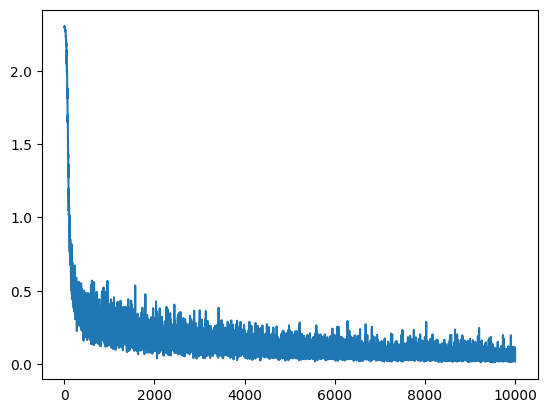

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list)

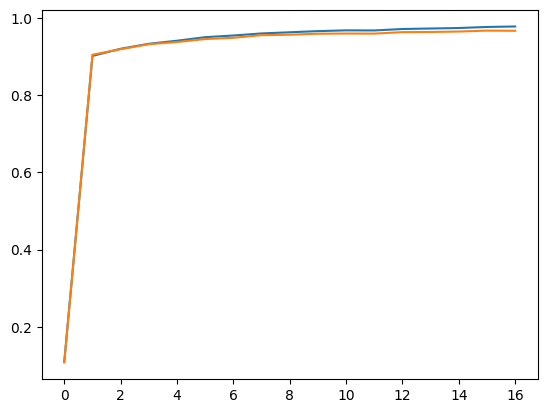

In [9]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)